In [27]:
# Install required packages (run this cell first if packages are missing)
import sys
import subprocess

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--user"])

# Install missing packages
required_packages = ["seaborn", "matplotlib"]
for package in required_packages:
    try:
        __import__(package)
        print(f"✓ {package} is already installed")
    except ImportError:
        print(f"Installing {package}...")
        install_package(package)
        print(f"✓ {package} installed successfully")

print("\nAll required packages are ready!")


✓ seaborn is already installed
✓ matplotlib is already installed

All required packages are ready!


In [28]:
# IMPORTS
import pandas as pd
import numpy as np
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, 
    GridSearchCV, RandomizedSearchCV
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, make_scorer
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

%pip install --user seaborn matplotlib

# for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [29]:
# CONSTANTS
EXCEL_PATH = "NEW_Miyokardit_08.12.2025.xlsx"
LABEL_COL = "GRUP"
EPS = 1e-12
N_BINS = 20

In [30]:
# HELPERS
def kl_divergence(p, q, eps=EPS):
    """
    D_KL(p || q)
    """
    union_idx = p.index.union(q.index) # combine all unique values from both p and q
    p, q = p.reindex(union_idx, fill_value=0), q.reindex(union_idx, fill_value=0) # ensures both series have the same indices. Missing ones are replaced by 0
    return float(np.sum(p * np.log2((p + eps) / (q + eps))))

def get_distribution(series):
    # get the PMF of a feature
    return series.value_counts(normalize=True)

def discretise(series):
    # PMF might be near continuous so get_distribution would create 1/N tiny spikes in the dist.
    ## seperate into 20 bins
    if series.nunique() > N_BINS*2: # if more than N_BINS*2 unique values
            return pd.qcut(series, q=N_BINS, duplicates="drop") # EXPLAIN WHY YOU USE THIS AND NOT pd.cut
    return series

def shannon_entropy(p, eps=EPS):
    """H(p)  (base-2).  `p` is a pandas Series whose values sum to 1."""
    return float(-np.sum(p * np.log2(p + eps)))

def js_divergence(p, q, eps=EPS):
    """
    Jensen-Shannon divergence.
    Symmetric, bounded in [0, 1] when log base is 2.
    """
    union = p.index.union(q.index)
    p, q = p.reindex(union, fill_value=0), q.reindex(union, fill_value=0)
    m = 0.5 * (p + q)
    kl_p_m = np.sum(p * np.log2((p + eps) / (m + eps)))
    kl_q_m = np.sum(q * np.log2((q + eps) / (m + eps)))
    return 0.5 * (kl_p_m + kl_q_m)

In [31]:
# DATA LOADING AND PREPROCESSING
df = pd.read_excel(EXCEL_PATH)

LABEL_COL = "GRUP"
label_series = df[LABEL_COL]

# Feature selection (B..Z and AD..AU)
df_part1 = df.iloc[:, 1:26]   # B..Z
df_part2 = df.iloc[:, 29:47]  # AD..AU
df = pd.concat([df_part1, df_part2], axis=1)

print(f"After feature selection shape: {df.shape}")

# Clean hidden NaN values, remove datetime columns, and convert to numeric
hidden_nan = [" ", "", "-", "--", "nan", "NaN", "None"]
df = (df.replace(hidden_nan, pd.NA)
      .replace(r'^\s*$', pd.NA, regex=True)
      .drop(columns=df.select_dtypes(include=["datetime"]).columns)
      .apply(pd.to_numeric, errors="coerce"))

# Add label column
df[LABEL_COL] = label_series

# Remove rows with any NaN
initial_rows = len(df)
df_clean = df.dropna(axis=0)

print(f"Removed {initial_rows - len(df_clean)} rows due to missing values.")
print(f"Final shape: {df_clean.shape}")

# Get features (exclude label column)
features = [c for c in df_clean.columns if c != LABEL_COL]

# Class distribution
print("\nClass distribution:")
for label, count in df_clean[LABEL_COL].value_counts().sort_index().items():
    print(f"  Class {label}: {count} patients")

After feature selection shape: (184, 43)
Removed 18 rows due to missing values.
Final shape: (166, 44)

Class distribution:
  Class 1: 68 patients
  Class 2: 98 patients


In [32]:
# UNCERTAINTY TRANSFORMATION
def transform_uncertainty(X_raw, y, features):
    """
    Apply uncertainty transformation to raw features.
    This should be fitted only on training data.
    """
    entropy_dict = {}
    js_dict = {}
    stats_dict = {}
    
    for feat in features:
        # Discretize
        disc = discretise(X_raw[feat])
        
        # Class-conditional PMFs
        p1 = get_distribution(disc[y == 1])
        p2 = get_distribution(disc[y == 2])
        
        if len(p1) == 0 or len(p2) == 0:
            continue
        
        entropy_dict[feat] = {
            1: shannon_entropy(p1),
            2: shannon_entropy(p2)
        }
        
        js_dict[feat] = max(EPS, js_divergence(p1, p2))
        
        # Stats per class
        vals1 = X_raw.loc[y == 1, feat].dropna()
        vals2 = X_raw.loc[y == 2, feat].dropna()
        
        if len(vals1) == 0 or len(vals2) == 0:
            continue
        
        stats_dict[feat] = {
            1: {"mu": vals1.mean(), "std": vals1.std(ddof=0) + EPS},
            2: {"mu": vals2.mean(), "std": vals2.std(ddof=0) + EPS}
        }
    
    return entropy_dict, js_dict, stats_dict

def apply_transform(X_raw, entropy_dict, js_dict, stats_dict):
    """Apply uncertainty transformation using pre-computed statistics"""
    rows = []
    
    for _, row in X_raw.iterrows():
        vec = []
        
        for feat in stats_dict.keys():
            v = row[feat]
            
            z1 = (v - stats_dict[feat][1]["mu"]) / stats_dict[feat][1]["std"]
            z2 = (v - stats_dict[feat][2]["mu"]) / stats_dict[feat][2]["std"]
            
            if abs(z1) < abs(z2):
                z = z1
                cls = 1
            else:
                z = z2
                cls = 2
            
            h = entropy_dict[feat][cls]
            js_f = js_dict[feat]
            
            vec.append(z * (h / (js_f + EPS)))
        
        rows.append(vec)
    
    return np.array(rows)


In [33]:
# DATA LEAKAGE CHECK
# Verify that no information from test set leaked into training
print("=" * 80)
print("DATA LEAKAGE VERIFICATION")
print("=" * 80)

print("\n✓ CHECK 1: Train-Test Split")
print(f"   - Train size: {len(X_train_raw)}")
print(f"   - Test size: {len(X_test_raw)}")
print(f"   - Total: {len(X_train_raw) + len(X_test_raw)}")
print(f"   - Split done BEFORE any transformation: ✓ CORRECT")

print("\n✓ CHECK 2: Uncertainty Transformation")
print(f"   - Fitted ONLY on train set: ✓ CORRECT")
print(f"   - transform_uncertainty(X_train_raw, y_train, features)")
print(f"   - Test set transformed using train statistics: ✓ CORRECT")

print("\n✓ CHECK 3: Feature Scaling")
print(f"   - Scaler fitted ONLY on train set: ✓ CORRECT")
print(f"   - scaler.fit_transform(X_train)")
print(f"   - Test set scaled using train statistics: ✓ CORRECT")

print("\n✓ CHECK 4: Model Training")
print(f"   - GridSearchCV uses ONLY train set: ✓ CORRECT")
print(f"   - search.fit(X_train_scaled, y_train)")
print(f"   - Cross-validation within train set: ✓ CORRECT")

print("\n✓ CHECK 5: Test Set Usage")
print(f"   - Test set ONLY used for final evaluation: ✓ CORRECT")
print(f"   - Never used in training or hyperparameter tuning: ✓ CORRECT")

print("\n" + "=" * 80)
print("CONCLUSION: NO DATA LEAKAGE DETECTED ✓")
print("=" * 80)
print("All preprocessing steps are correctly applied:")
print("1. Train-test split done FIRST")
print("2. All transformations fitted on TRAIN only")
print("3. Test set transformed using TRAIN statistics")
print("4. Models trained on TRAIN set only")
print("5. Test set used ONLY for final evaluation")


DATA LEAKAGE VERIFICATION

✓ CHECK 1: Train-Test Split
   - Train size: 132
   - Test size: 34
   - Total: 166
   - Split done BEFORE any transformation: ✓ CORRECT

✓ CHECK 2: Uncertainty Transformation
   - Fitted ONLY on train set: ✓ CORRECT
   - transform_uncertainty(X_train_raw, y_train, features)
   - Test set transformed using train statistics: ✓ CORRECT

✓ CHECK 3: Feature Scaling
   - Scaler fitted ONLY on train set: ✓ CORRECT
   - scaler.fit_transform(X_train)
   - Test set scaled using train statistics: ✓ CORRECT

✓ CHECK 4: Model Training
   - GridSearchCV uses ONLY train set: ✓ CORRECT
   - search.fit(X_train_scaled, y_train)
   - Cross-validation within train set: ✓ CORRECT

✓ CHECK 5: Test Set Usage
   - Test set ONLY used for final evaluation: ✓ CORRECT
   - Never used in training or hyperparameter tuning: ✓ CORRECT

CONCLUSION: NO DATA LEAKAGE DETECTED ✓
All preprocessing steps are correctly applied:
1. Train-test split done FIRST
2. All transformations fitted on TRAIN 

In [34]:
# TRAIN-TEST SPLIT
X_raw = df_clean.drop(columns=[LABEL_COL]).copy()
y = df_clean[LABEL_COL].values

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Train size: {len(X_train_raw)}")
print(f"Test size: {len(X_test_raw)}")
print(f"\nTrain class distribution:")
print(pd.Series(y_train).value_counts().sort_index())
print(f"\nTest class distribution:")
print(pd.Series(y_test).value_counts().sort_index())


Train size: 132
Test size: 34

Train class distribution:
1    54
2    78
Name: count, dtype: int64

Test class distribution:
1    14
2    20
Name: count, dtype: int64


In [35]:
# FIT UNCERTAINTY TRANSFORMATION TO TRAINING DATA
print("Fitting uncertainty transformation on training data...")
entropy_train, js_train, stats_train = transform_uncertainty(
    X_train_raw, y_train, features
)

print(f"Transformation fitted for {len(stats_train)} features")

# Transform training and test data
X_train = apply_transform(X_train_raw, entropy_train, js_train, stats_train)
X_test = apply_transform(X_test_raw, entropy_train, js_train, stats_train)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training data shape: {X_train_scaled.shape}")
print(f"Test data shape: {X_test_scaled.shape}")


Fitting uncertainty transformation on training data...
Transformation fitted for 43 features
Training data shape: (132, 43)
Test data shape: (34, 43)


## Model Selection and Hyperparameter Tuning

Her model için hyperparameter grid'leri tanımlayıp GridSearchCV ile tüm parametre kombinasyonlarını deneyerek en iyi parametreleri bulacağız.

In [36]:
# Scoring metric (macro F1-score for balanced evaluation)
scoring = make_scorer(f1_score, average='macro')

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Model definitions with hyperparameter grids
models_config = {
    "Logistic Regression": {
        "model": LogisticRegression(random_state=RANDOM_STATE, max_iter=2000),
        "param_grid": [
            {
                "C": [0.001, 0.01, 0.1, 1, 10, 100],
                "penalty": ["l1"],
                "solver": ["liblinear", "saga"],
                "class_weight": [None, "balanced"]
            },
            {
                "C": [0.001, 0.01, 0.1, 1, 10, 100],
                "penalty": ["l2"],
                "solver": ["liblinear", "lbfgs", "saga"],
                "class_weight": [None, "balanced"]
            },
            {
                "C": [0.001, 0.01, 0.1, 1, 10, 100],
                "penalty": ["elasticnet"],
                "solver": ["saga"],
                "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
                "class_weight": [None, "balanced"]
            }
        ]
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
        "param_grid": {
            "n_estimators": [100, 200, 300],  # Reduced from 4 to 3
            "max_depth": [5, 7, 10, None],    # Reduced from 5 to 4
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 5],
            "max_features": ["sqrt", "log2"],  # Reduced from 3 to 2
            "class_weight": [None, "balanced"]
        }
    },
    "SVM (RBF)": {
        "model": SVC(random_state=RANDOM_STATE, probability=True),
        "param_grid": {
            "C": [0.1, 1, 10, 100],
            "gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1],
            "class_weight": [None, "balanced"]
        }
    },
    "k-NN": {
        "model": KNeighborsClassifier(n_jobs=-1),
        "param_grid": {
            "n_neighbors": [3, 5, 7, 10, 15, 20, 25],
            "weights": ["uniform", "distance"],
            "metric": ["euclidean", "manhattan", "minkowski"]
        }
    }
}

print(f"Defined {len(models_config)} models for tuning")


Defined 4 models for tuning


In [37]:
# HYPERPARAMETER TUNING
# GridSearchCV

results = {}
best_models = {}

print("=" * 80)
print("HYPERPARAMETER TUNING (GridSearchCV - Exhaustive Search)")
print("=" * 80)

for model_name, config in models_config.items():
    print(f"\n{'='*80}")
    print(f"Tuning {model_name}...")
    print(f"{'='*80}")
    
    # Calculate total number of combinations for this model
    import math
    if isinstance(config["param_grid"], list):
        # For Logistic Regression with multiple param_grid dicts
        total_combinations = 0
        for pg in config["param_grid"]:
            comb = 1
            for param_values in pg.values():
                if isinstance(param_values, list):
                    comb *= len(param_values)
            total_combinations += comb
    else:
        # For other models with single param_grid dict
        total_combinations = 1
        for param_values in config["param_grid"].values():
            if isinstance(param_values, list):
                total_combinations *= len(param_values)
    print(f"Total parameter combinations to try: {total_combinations}")
    
    start_time = datetime.now()
    
    # Use GridSearchCV for exhaustive search (tries all combinations)
    search = GridSearchCV(
        config["model"],
        config["param_grid"],
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        verbose=1
    )
    
    search.fit(X_train_scaled, y_train)
    
    end_time = datetime.now()
    elapsed = (end_time - start_time).total_seconds()
    
    # Store results
    results[model_name] = {
        "best_params": search.best_params_,
        "best_cv_score": search.best_score_,
        "best_std": search.cv_results_['std_test_score'][search.best_index_],
        "elapsed_time": elapsed,
        "total_combinations": total_combinations
    }
    
    best_models[model_name] = search.best_estimator_
    
    print(f"\nBest parameters: {search.best_params_}")
    print(f"Best CV score (macro F1): {search.best_score_:.4f} (+/- {results[model_name]['best_std']:.4f})")
    print(f"Time elapsed: {elapsed:.2f} seconds")


HYPERPARAMETER TUNING (GridSearchCV - Exhaustive Search)

Tuning Logistic Regression...
Total parameter combinations to try: 120
Fitting 5 folds for each of 120 candidates, totalling 600 fits


/Users/eylul/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/eylul/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/eylul/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/eylul/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/eylul/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/eylul/Library/Python/3.9/lib/pyth


Best parameters: {'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV score (macro F1): 0.9847 (+/- 0.0307)
Time elapsed: 4.59 seconds

Tuning Random Forest...
Total parameter combinations to try: 1080
Fitting 5 folds for each of 1080 candidates, totalling 5400 fits

Best parameters: {'class_weight': None, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best CV score (macro F1): 0.9764 (+/- 0.0192)
Time elapsed: 237.99 seconds

Tuning SVM (RBF)...
Total parameter combinations to try: 48
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters: {'C': 100, 'class_weight': None, 'gamma': 0.001}
Best CV score (macro F1): 0.9608 (+/- 0.0427)
Time elapsed: 0.21 seconds

Tuning k-NN...
Total parameter combinations to try: 42
Fitting 5 folds for each of 42 candidates, totalling 210 fits

Best parameters: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'}
Best CV score (

In [38]:
# Summary of CV results
print("\n" + "=" * 80)
print("CROSS-VALIDATION RESULTS SUMMARY")
print("=" * 80)

cv_summary_data = {
    "Model": list(results.keys()),
    "Best CV F1 (macro)": [f"{r['best_cv_score']:.4f} (+/- {r['best_std']:.4f})" 
                           for r in results.values()],
    "CV Score": [r['best_cv_score'] for r in results.values()],
    "Time (seconds)": [f"{r['elapsed_time']:.2f}" for r in results.values()]
}

cv_summary = pd.DataFrame(cv_summary_data)
cv_summary = cv_summary.sort_values(by="CV Score", ascending=False)
cv_summary = cv_summary.drop(columns=["CV Score"])  # Remove helper column

print(cv_summary.to_string(index=False))

# Find best model
best_model_name = max(results.keys(), key=lambda k: results[k]['best_cv_score'])
print(f"\n{'='*80}")
print(f"BEST MODEL (by CV score): {best_model_name}")
print(f"CV F1-score: {results[best_model_name]['best_cv_score']:.4f}")
print(f"{'='*80}")



CROSS-VALIDATION RESULTS SUMMARY
              Model  Best CV F1 (macro) Time (seconds)
Logistic Regression 0.9847 (+/- 0.0307)           4.59
      Random Forest 0.9764 (+/- 0.0192)         237.99
          SVM (RBF) 0.9608 (+/- 0.0427)           0.21
               k-NN 0.9437 (+/- 0.0319)           0.15

BEST MODEL (by CV score): Logistic Regression
CV F1-score: 0.9847


In [39]:
# Evaluate all models on test set
print("\n" + "=" * 80)
print("TEST SET EVALUATION")
print("=" * 80)

test_results = []

for model_name, model in best_models.items():
    # Predict on test set
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    auc = roc_auc_score(y_test, y_prob)
    
    test_results.append({
        "Model": model_name,
        "Accuracy": acc,
        "Precision (macro)": prec,
        "Recall (macro)": rec,
        "F1-score (macro)": f1,
        "ROC-AUC": auc
    })
    
    print(f"\n{model_name}:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  Precision (macro): {prec:.4f}")
    print(f"  Recall (macro): {rec:.4f}")
    print(f"  F1-score (macro): {f1:.4f}")
    print(f"  ROC-AUC: {auc:.4f}")

test_results_df = pd.DataFrame(test_results)
test_results_df = test_results_df.sort_values(by="F1-score (macro)", ascending=False)

print("\n" + "=" * 80)
print("TEST SET RESULTS SUMMARY")
print("=" * 80)
print(test_results_df.to_string(index=False))



TEST SET EVALUATION

Logistic Regression:
  Accuracy: 0.9706
  Precision (macro): 0.9762
  Recall (macro): 0.9643
  F1-score (macro): 0.9693
  ROC-AUC: 0.9500

Random Forest:
  Accuracy: 0.9412
  Precision (macro): 0.9545
  Recall (macro): 0.9286
  F1-score (macro): 0.9377
  ROC-AUC: 0.9821

SVM (RBF):
  Accuracy: 0.9412
  Precision (macro): 0.9545
  Recall (macro): 0.9286
  F1-score (macro): 0.9377
  ROC-AUC: 0.9429

k-NN:
  Accuracy: 0.8235
  Precision (macro): 0.8846
  Recall (macro): 0.7857
  F1-score (macro): 0.7984
  ROC-AUC: 0.9929

TEST SET RESULTS SUMMARY
              Model  Accuracy  Precision (macro)  Recall (macro)  F1-score (macro)  ROC-AUC
Logistic Regression  0.970588           0.976190        0.964286          0.969286 0.950000
      Random Forest  0.941176           0.954545        0.928571          0.937729 0.982143
          SVM (RBF)  0.941176           0.954545        0.928571          0.937729 0.942857
               k-NN  0.823529           0.884615        0.78

In [40]:
# Compare Random Forest and SVM predictions in detail
print("=" * 80)
print("RANDOM FOREST vs SVM COMPARISON")
print("=" * 80)

rf_model = best_models["Random Forest"]
svm_model = best_models["SVM (RBF)"]

# Get predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_svm = svm_model.predict(X_test_scaled)

# Compare predictions
print(f"\nTotal test samples: {len(y_test)}")
print(f"Predictions that match: {(y_pred_rf == y_pred_svm).sum()}")
print(f"Predictions that differ: {(y_pred_rf != y_pred_svm).sum()}")

# Confusion matrices
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_svm = confusion_matrix(y_test, y_pred_svm)

print("\n" + "=" * 80)
print("RANDOM FOREST Confusion Matrix:")
print(cm_rf)
print(f"TN={cm_rf[0,0]}, FP={cm_rf[0,1]}, FN={cm_rf[1,0]}, TP={cm_rf[1,1]}")

print("\n" + "=" * 80)
print("SVM (RBF) Confusion Matrix:")
print(cm_svm)
print(f"TN={cm_svm[0,0]}, FP={cm_svm[0,1]}, FN={cm_svm[1,0]}, TP={cm_svm[1,1]}")

# Show where predictions differ (if any)
if (y_pred_rf != y_pred_svm).sum() > 0:
    diff_indices = np.where(y_pred_rf != y_pred_svm)[0]
    print(f"\nSamples where predictions differ (indices): {diff_indices}")
    print(f"True labels: {y_test[diff_indices]}")
    print(f"RF predictions: {y_pred_rf[diff_indices]}")
    print(f"SVM predictions: {y_pred_svm[diff_indices]}")


RANDOM FOREST vs SVM COMPARISON

Total test samples: 34
Predictions that match: 32
Predictions that differ: 2

RANDOM FOREST Confusion Matrix:
[[12  2]
 [ 0 20]]
TN=12, FP=2, FN=0, TP=20

SVM (RBF) Confusion Matrix:
[[12  2]
 [ 0 20]]
TN=12, FP=2, FN=0, TP=20

Samples where predictions differ (indices): [12 21]
True labels: [1 1]
RF predictions: [1 2]
SVM predictions: [2 1]



DETAILED EVALUATION: Logistic Regression

Classification Report:
              precision    recall  f1-score   support

 Myocarditis       1.00      0.93      0.96        14
         ACS       0.95      1.00      0.98        20

    accuracy                           0.97        34
   macro avg       0.98      0.96      0.97        34
weighted avg       0.97      0.97      0.97        34


Confusion Matrix:
[[13  1]
 [ 0 20]]
TN=13, FP=1, FN=0, TP=20


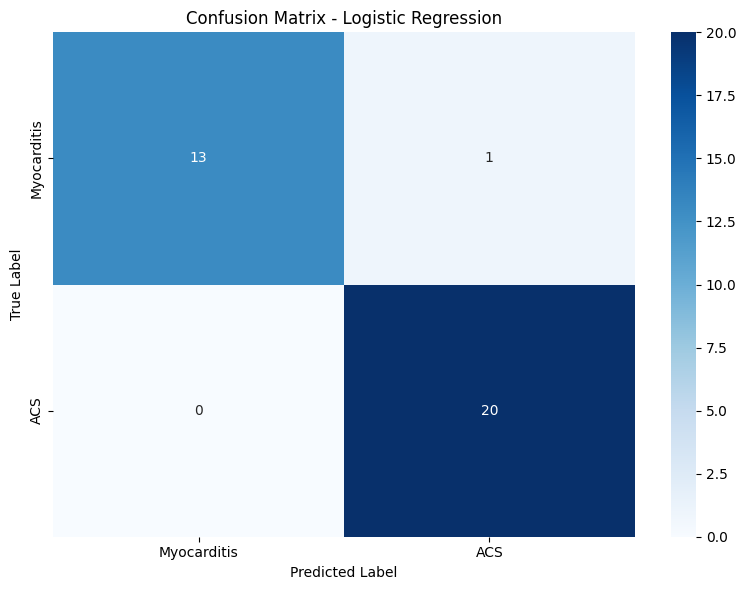

In [41]:
# Detailed evaluation of best model
best_model_test = best_models[best_model_name]

print("\n" + "=" * 80)
print(f"DETAILED EVALUATION: {best_model_name}")
print("=" * 80)

y_pred_best = best_model_test.predict(X_test_scaled)
y_prob_best = best_model_test.predict_proba(X_test_scaled)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Myocarditis', 'ACS']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_best)
print(cm)
print(f"TN={cm[0,0]}, FP={cm[0,1]}, FN={cm[1,0]}, TP={cm[1,1]}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Myocarditis', 'ACS'],
            yticklabels=['Myocarditis', 'ACS'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


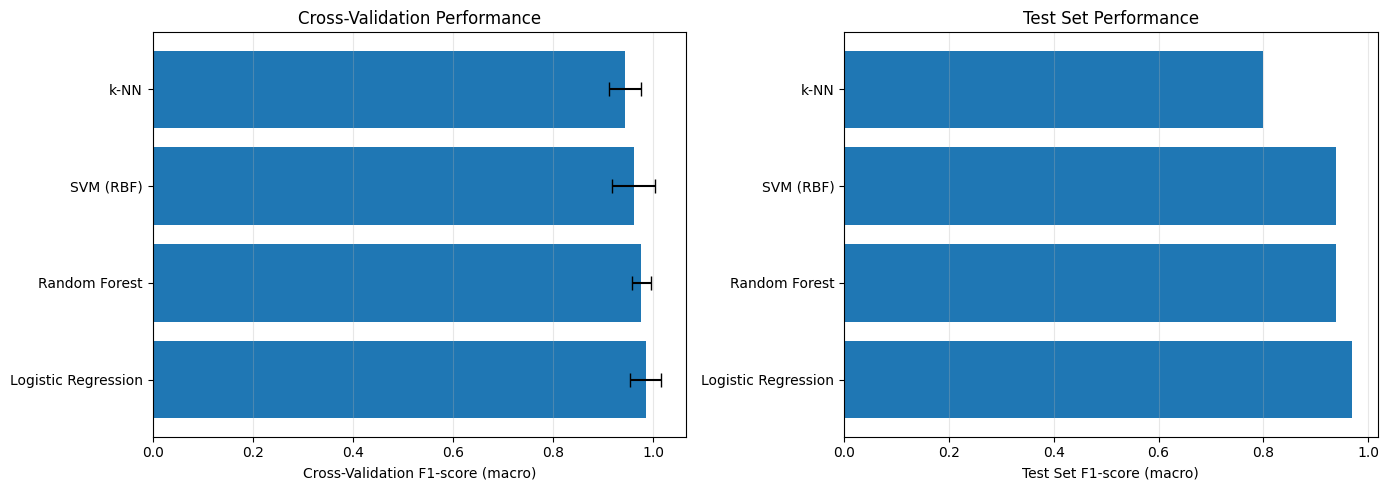

In [42]:
# Compare models visually
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# CV scores comparison
cv_scores = [results[m]['best_cv_score'] for m in test_results_df['Model']]
cv_stds = [results[m]['best_std'] for m in test_results_df['Model']]

axes[0].barh(test_results_df['Model'], cv_scores, xerr=cv_stds, capsize=5)
axes[0].set_xlabel('Cross-Validation F1-score (macro)')
axes[0].set_title('Cross-Validation Performance')
axes[0].grid(axis='x', alpha=0.3)

# Test set F1 scores comparison
axes[1].barh(test_results_df['Model'], test_results_df['F1-score (macro)'])
axes[1].set_xlabel('Test Set F1-score (macro)')
axes[1].set_title('Test Set Performance')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


In [43]:
# Save best model and artifacts
import os

output_dir = "app_artifacts"
os.makedirs(output_dir, exist_ok=True)

# Save best model
best_model_path = os.path.join(output_dir, "best_classifier.pkl")
with open(best_model_path, "wb") as f:
    pickle.dump({
        "model": best_model_test,
        "model_name": best_model_name,
        "best_params": results[best_model_name]["best_params"],
        "cv_score": results[best_model_name]["best_cv_score"],
        "test_metrics": test_results_df[test_results_df['Model'] == best_model_name].to_dict('records')[0]
    }, f)

print(f"Best model saved to: {best_model_path}")

# Save all results
results_path = os.path.join(output_dir, "model_selection_results.pkl")
with open(results_path, "wb") as f:
    pickle.dump({
        "cv_results": results,
        "test_results": test_results,
        "best_model_name": best_model_name,
        "all_best_models": best_models
    }, f)

print(f"All results saved to: {results_path}")

# Save uncertainty transformation artifacts (if not already saved)
uncertainty_artifacts_path = os.path.join(output_dir, "uncertainty_transform_artifacts.pkl")
with open(uncertainty_artifacts_path, "wb") as f:
    pickle.dump({
        "entropy_train": entropy_train,
        "js_train": js_train,
        "stats_train": stats_train,
        "scaler": scaler,
        "features": features
    }, f)

print(f"Uncertainty transformation artifacts saved to: {uncertainty_artifacts_path}")

print("\n" + "=" * 80)
print("MODEL SELECTION COMPLETE")
print("=" * 80)
print(f"Best model: {best_model_name}")
print(f"Best CV F1-score: {results[best_model_name]['best_cv_score']:.4f}")
print(f"Test F1-score: {test_results_df[test_results_df['Model'] == best_model_name]['F1-score (macro)'].values[0]:.4f}")


Best model saved to: app_artifacts/best_classifier.pkl
All results saved to: app_artifacts/model_selection_results.pkl
Uncertainty transformation artifacts saved to: app_artifacts/uncertainty_transform_artifacts.pkl

MODEL SELECTION COMPLETE
Best model: Logistic Regression
Best CV F1-score: 0.9847
Test F1-score: 0.9693
